In [1]:
#Headers for the analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.svm import SVR




from numpy import array
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Input

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

np.random.seed(1234)
tf.random.set_seed(1234)

import timeit



2024-08-13 12:04:14.901853: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 12:04:15.146646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 12:04:15.146701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 12:04:15.147794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 12:04:15.253979: I tensorflow/core/platform/cpu_feature_g

In [6]:
#Filler functions
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))#, squared=False)
# Fixed values for the device, not going to change based on our requirement

freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]
freq_dict['bFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000]
# cost_list =['cCost','mCost','gCost']
cFreq = 'bFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'

cost2FMap = {}
cost2FMap['cCost'] = 'bFreq'
cost2FMap['mCost'] = 'mFreq'
cost2FMap['gCost'] = 'gFreq'

## Function to extract the files and send a dataframe

def extractDatafromFile(fileName='./UtilTestFinal',padding=0): ## Generally make the padding 0
    new_data = pd.read_csv(fileName)
    #### This part needs to be 
    if padding == 1:  # if there is not 
        new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = 0
        new_data['gFreq'] = 600000000
    elif padding == 2:  # if there is not 
        # new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        # new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = new_data['gCost']*new_data['gFreq']/600000000
        # new_data['gFreq'] = 600000000

    return new_data

#extractDatafromFile()
# Getting the exog list for analysis

def getExog(endog='cCost'):
    cost_list =['cCost','mCost','gCost']
    if endog not in cost_list:
        print("Incorrect Value")
        return None,None
    else:
        my_list = []
        for res in cost_list:
            if res != endog:
                my_list.append(res)
        return my_list[0],my_list[1]

# getExog('gCost')

## Function to shift the data, enabling testing and trainig

def createRequiredDataSet(input_df,endog,shiftAR,shiftARX,b_exog=True):
    modified_df = pd.DataFrame()
    ## Get the exog values
    exog,exog1 = getExog(endog)
    if b_exog == True:
        modified_df = input_df[[endog,exog,exog1]]
    else:
        modified_df = input_df[[endog]]
    # Shifting the endog data
    for i in range(1,shiftAR+1):
        modified_df['%s_%d'%(endog,i)] = modified_df[endog].shift(i)
    if b_exog==True:
    # Shifting the exog and exog1 data
        modified_df[exog] = modified_df[exog].shift(1)
        modified_df[exog1] = modified_df[exog1].shift(1)
    
        for i in range(1,shiftARX+1):
            modified_df['%s_%d'%(exog,i)] = modified_df[exog].shift(i+1)
            modified_df['%s_%d'%(exog1,i)] = modified_df[exog1].shift(i+1)

    # Adding the frequency stuff
    modified_df[cFreq] = input_df[cFreq] 
    modified_df[mFreq] = input_df[mFreq] 
    modified_df[gFreq] = input_df[gFreq] 
    modified_df = modified_df.dropna()
    return modified_df


## Test_train divide

def test_train_split(input_df,trainIDX,testIDX,perc=0.8):
    totalLen = len(input_df)
    if trainIDX == -1 or testIDX == -1:
        trainIDX = int(perc*totalLen)
        testIDX = int(perc*totalLen)
    train_df = input_df.iloc[:trainIDX,:]
    test_df = input_df.iloc[testIDX:,:]
    return train_df,test_df


## get the matrices for training, we are assuming that 0 is the y value and the rest are x, we can choose to skip few columns

def getYXData(input_df,ignoreCols=0):
    totalLen = len(input_df.columns)
    y_data = input_df.iloc[:,0].to_numpy()
    x_data = input_df.iloc[:,1:totalLen-ignoreCols].to_numpy()
    return y_data,x_data


def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u


def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result



def simple_test_single(model, xData):
    newX = [1.0]
    newX.extend(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    return y_pred

def getSingleCluster(data, cntr):
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([data]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut


def prediction(model,x,cluster):
    ## get cluster
    N_CLUST = len(model)
    prob_d = getSingleCluster(x,cluster).T[0]
    y = []
    for i in range(N_CLUST):
        ys = simple_test_single(model[i],x)
        y.append(ys*prob_d[i])
    my_pred = min(sum(y)[0],100.0)
    return my_pred


# Prediction of just simple Mean
def prediction_mean(x,hist):
    ## get cluster
    # N_CLUST = len(model)
    # prob_d = getSingleCluster(x,cluster).T[0]
    # y = []
    # for i in range(N_CLUST):
    #     ys = simple_test_single(model[i],x)
    #     y.append(ys*prob_d[i])
    my_pred = np.mean(x[:hist])
    return my_pred

In [7]:
# def getPredF(est_util, act_util, freq_list):
#     eff_u = -1
#     max_f = max(freq_list)
#     est_freq = max_f
#     for f in freq_list:
#         eff_u = est_util * max_f/f
#         if eff_u <=100 or f == max_f:
#             eff_y = act_util * max_f/f
#             return f,eff_u,eff_y
#     return max_f,-1,-1
def getPredF(est_util, act_util, freq_list): ## Take the higher frequency if possible
    eff_u = -1
    max_f = max(freq_list)
    est_freq = max_f
    for fidx in range(len(freq_list)):
        f = freq_list[fidx]
        eff_u = est_util * max_f/f
        if eff_u <=100 or f == max_f:
            eff_y = act_util * max_f/freq_list[min(fidx+1,len(freq_list)-1)]
            return f,eff_u,eff_y
    return max_f,-1,-1
def energy_perf_analysis(y_act,y_est,act_freq,endog, details=False):
    eff_util = []
    est_freq = []
    possible_freq_config = freq_dict[cost2FMap[endog]] ## list of all possible frequency in increasing order
    LEN = len(y_act)
    energy_save = 0.
    for idx in range(LEN):
        pred_f, eff_u, eff_y = getPredF(y_est[idx],y_act[idx],possible_freq_config)
        eff_util.append(eff_y)
        est_freq.append(pred_f)
        # print(pred_f, act_freq[idx])
        energy_save += math.ceil(eff_y/100.) * (pred_f/act_freq[idx])**2
        
        
    stall = (sum( i > 100 for i in eff_util ) * 100) / LEN
    energy_ratio = 1.0 - (energy_save/LEN)
    if details:
        return stall, energy_ratio, est_freq, eff_util
    return stall, energy_ratio

    
## Plot the error
def plotErrDist(y_est,y_actual,bins=10):
    err = np.array(y_est) - np.array(y_actual)
    print("min:",min(err),", max : ",max(err))
    ybins, xbins, bar = plt.hist(err, color='lightblue', ec='black', bins=bins)
    print("Mode error: ", xbins[np.argmax(ybins)])
    plt.show()
    return
    

In [8]:
# ##n imports

# from numpy import array
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# from keras.layers import Dense, LSTM
# from keras.models import Sequential
# from keras.layers import Input

# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers import Conv1D
# from keras.layers import MaxPooling1D
# np.random.seed(1234)
# tf.random.set_seed(1234)

## Lets do univariate models


def getUnivariateDataSplit(listData, shiftAR=8): # This will create a new df so that we can run the LSTM
    modified_df = pd.DataFrame()
    modified_df['endog'] = listData
    for i in range(1,shiftAR+1):
        modified_df['endog_%d'%(i)] = modified_df['endog'].shift(i)
        
    modified_df = modified_df.dropna()
    return modified_df
    

    


# def LSTM(x_train,y_train,x_test,y_test):
#     pass



In [9]:
my_test = extractDatafromFile('./UtilMD.csv',2)
# MyData = getUnivariateDataSplit(my_test['cCost'].to_numpy(), shiftAR=8)
MyData = createRequiredDataSet(my_test,'cCost',8,-1,False)
train_df,test_df = test_train_split(MyData,trainIDX=1000,testIDX=1000,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)
#Reshape the data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
#LSTM 
n_steps = x_train.shape[1]
n_features = 1
# define model
model = Sequential()
model.add(LSTM(50, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=25, verbose=0)

2024-08-13 12:06:12.376765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 12:06:12.376884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 12:06:12.376934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
x_test_T = x_test[:200]
# x_test_r = x_test_T.reshape(200,n_steps,1)
yhat = model.predict(x_test_T, verbose=0)
# yhat
# yhat = np.array(yhat)
yOut = yhat.reshape(-1)
# yOut
rmse(yOut,y_test[:200])

39.10635291911819

In [7]:
## A different LSTM modeling ... with Conv Neural Network 

# Steps -- try to get the pipeline running....
my_test = extractDatafromFile('./UtilTestFinal',1)
MyData = getUnivariateDataSplit(my_test['cCost'].to_numpy(), shiftAR=8)
train_df,test_df = test_train_split(MyData,trainIDX=5000,testIDX=5000,perc=0.0)
y_train,x_train = getYXData(train_df)
y_test,x_test = getYXData(test_df)
#Reshape the data
n_features = 1
n_steps = 4
n_seq = 2
x_train = x_train.reshape(x_train.shape[0], n_seq, n_steps,n_features)
x_test = x_test.reshape(x_test.shape[0],n_seq, n_steps,n_features)
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#fit model
model.fit(x_train, y_train, epochs=25, verbose=0)




In [8]:
x_test_T = x_test[:2000]
# x_test_r = x_test_T.reshape(2000,n_steps,1)
yhat = model.predict(x_test_T, verbose=0)
# yhat
# yhat = np.array(yhat)
yOut = yhat.reshape(-1)
# yOut
rmse(yOut,y_test[:2000])

8.08203925478111

In [9]:
## LSTM Modeling....

my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='mCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)


## This might not be the best data respresentation, but we will get into it if requried.

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)

SVR()

In [10]:
my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='cCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)
    

SVR()

In [28]:
# svr_rbf.predict(X_test_scaled_T)

In [29]:
# y_test[:TEST_LEN]

<Axes: >

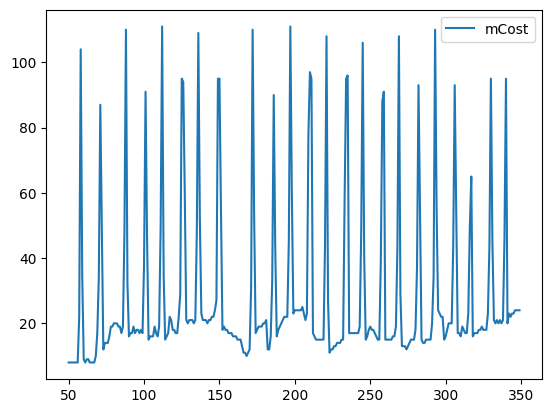

In [52]:
dataset = pd.read_csv('UtilMD.csv')
new_data = dataset[['cCost','mCost','gCost','gFreq']]
new_data['gCost'] = new_data['gCost']*new_data['gFreq']/600000000
# new_data[['cCost','gCost','mCost']].plot()
new_data[['mCost']].iloc[50:350].plot()

# Pipelined Approach 

In [10]:
def ModelPipeline_LSTM(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding)
    if shiftAR%2 == 1:
        shiftAR += 1
    MyData = createRequiredDataSet(my_test,endog,shiftAR,-1,False)
    train_df,test_df = test_train_split(MyData,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    #Reshape the data
    n_features = 1
    n_seq = 2
    n_steps = shiftAR//n_seq   
    x_train = x_train.reshape(x_train.shape[0], n_seq, n_steps,n_features)
    x_test = x_test.reshape(x_test.shape[0],n_seq, n_steps,n_features)
    #Train and fit the model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    #fit model
    start = timeit.default_timer()
    model.fit(x_train, y_train, epochs=25, verbose=0)
    stop = timeit.default_timer()

    print('Train Time: ', stop - start) 
    

    #Prediction using the model
    ys_actual = y_test[:TEST_LEN]
    x_test_T = x_test[:TEST_LEN]
    # x_test_r = x_test_T.reshape(2000,n_steps,1)
    ys_est = model.predict(x_test_T, verbose=0)
    ys_est = ys_est.reshape(-1)
    
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [11]:
def ModelPipeline_SVR(fileName,padding=0,endog='cCost',Kernel='rbf',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 1 for most of the data, except for the case where there is no GPU
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    start = timeit.default_timer()
    scaler = StandardScaler().fit(x_train)
    X_train_scaled = scaler.transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    svr = SVR(kernel = Kernel)
    svr.fit(X_train_scaled, y_train)
    stop = timeit.default_timer()
    print('Train Time: ', stop - start) 
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    X_test_scaled_T = X_test_scaled[:TEST_LEN]
    ys_est = svr.predict(X_test_scaled_T)
    # ys_est = []
    # for id in range(TEST_LEN):
    #     predVal = prediction(model,x_test[id],cluster_center)
    #     ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [12]:
def ModelPipeline_Mean(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    # ### Train the Model
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction_mean(x_test[id],shiftAR)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [15]:
def ModelPipeline(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    start = timeit.default_timer()
    cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    model = []
    for i in range(N_CLUST):
        out_model = simple_train(y_train,x_train,weight = prob[i,:])
        model.append(out_model)
    stop = timeit.default_timer()
    print('Train Time: ', stop - start) 
    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction(model,x_test[id],cluster_center)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [14]:
y_est,y_act,err,est_freq, act_freq,eff_util,stall,energy = ModelPipeline('./UtilMD.csv',padding=2,\
                                                                         endog='cCost',N_CLUST=3,shiftAR=10,shiftARX=3,\
                                                                         trainIDX=500,testIDX=500,TEST_LEN = 200)

Train Time:  0.04594953599996643


In [16]:
# ## 
# file='./UtilTestFinal'
# pad = 1
# test_endog = 'cCost'
# TrIDX = 5000
# TIDX = 5000
# TLEN = 2000

In [35]:
## 
file='./UtilMD.csv'
pad = 2
test_endog = 'mCost'
TrIDX = 500
TIDX = 500
TLEN = 200

Train Time:  0.0026970630000278106
#AR  2  RMSE : 13.031506644939105
min: -69.77229628090464 , max :  51.08886198102789
Mode error:  6.7731039516526295


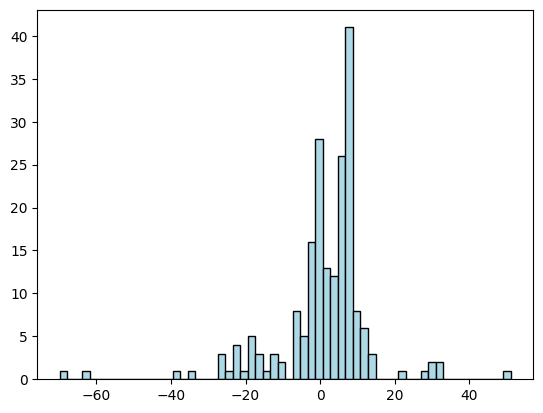

Train Time:  0.001875878999953784
#AR  3  RMSE : 13.272524030757008
min: -72.27533434674407 , max :  51.545465932377525
Mode error:  6.1445058300329265


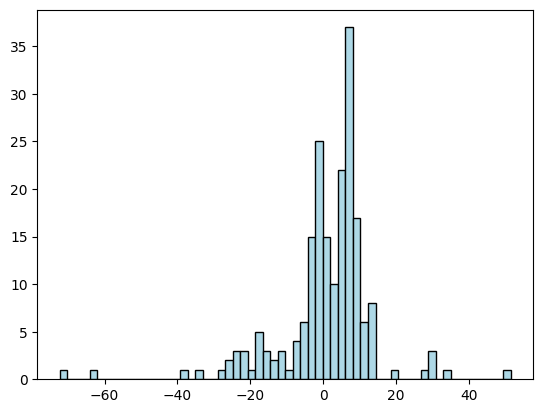

Train Time:  0.002878299000030893
#AR  4  RMSE : 13.572148987108235
min: -74.33700891123372 , max :  52.28322238554172
Mode error:  7.966141431670323


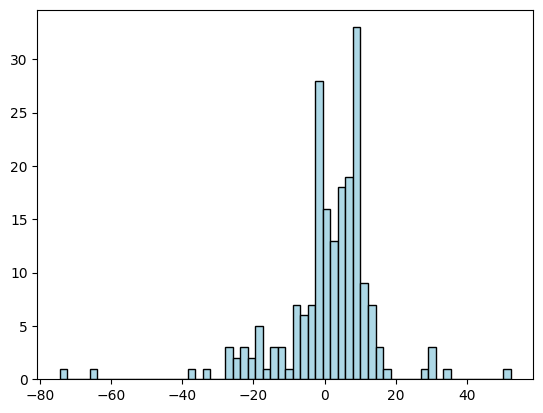

Train Time:  0.0031037900000683294
#AR  5  RMSE : 13.926056259410673
min: -76.85450158457637 , max :  51.94011242878453
Mode error:  9.008574424330902


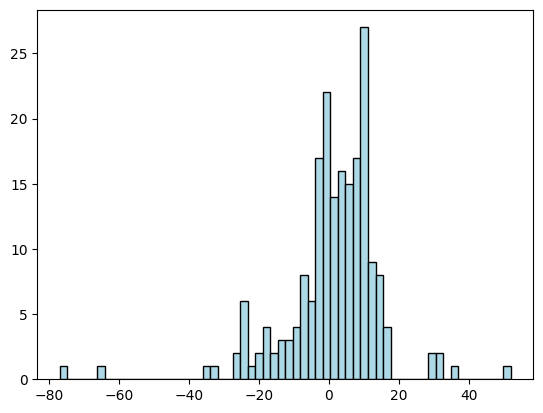

Train Time:  0.0030230879999635363
#AR  6  RMSE : 14.263006917609292
min: -80.38574593731303 , max :  46.49838877063158
Mode error:  10.54788393671393


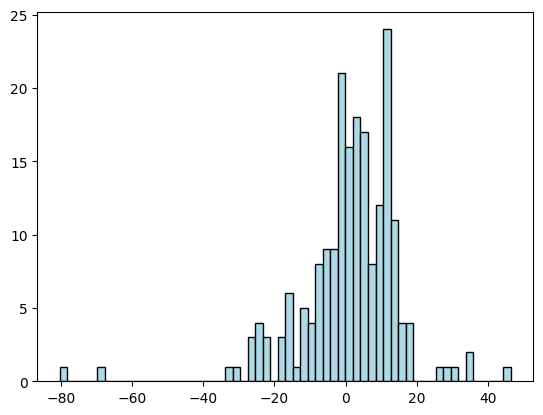

Train Time:  0.0037410939999062975
#AR  7  RMSE : 14.180391958790683
min: -78.58947775546399 , max :  45.5322390730274
Mode error:  2.0896381830554134


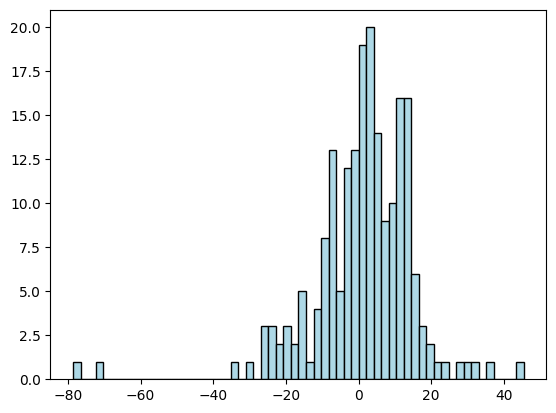

Train Time:  0.00588361999996323
#AR  8  RMSE : 14.08723914630909
min: -77.35310882528744 , max :  44.41193558271698
Mode error:  1.7941700399154428


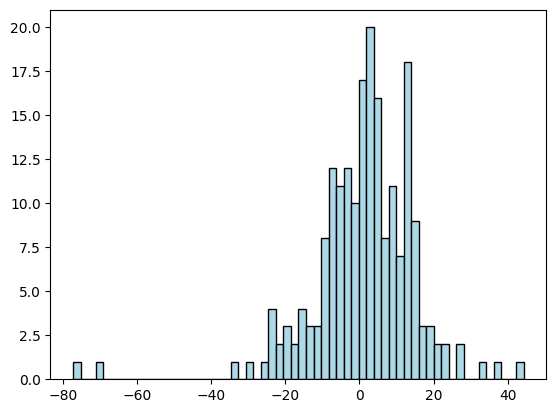

Train Time:  0.002006937000032849
#AR  9  RMSE : 14.1059134006367
min: -77.38922500242202 , max :  44.525482660782
Mode error:  1.8553349786605935


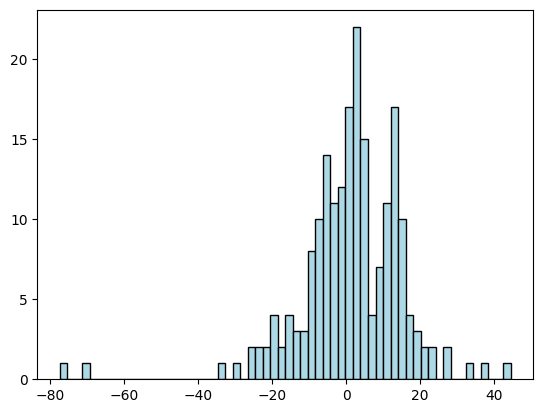

Train Time:  0.0019776880000108576
#AR  10  RMSE : 13.643076368858036
min: -76.27140927173758 , max :  45.930542885159454
Mode error:  1.1231604276305376


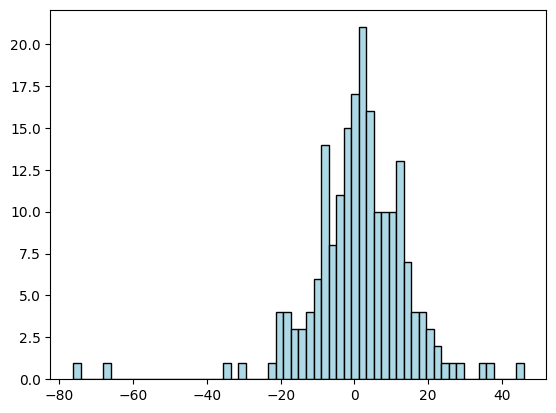

Train Time:  0.0027543460000742925
#AR  11  RMSE : 13.699295134337634
min: -75.89006357193327 , max :  46.8689962466611
Mode error:  -0.18864335046674796


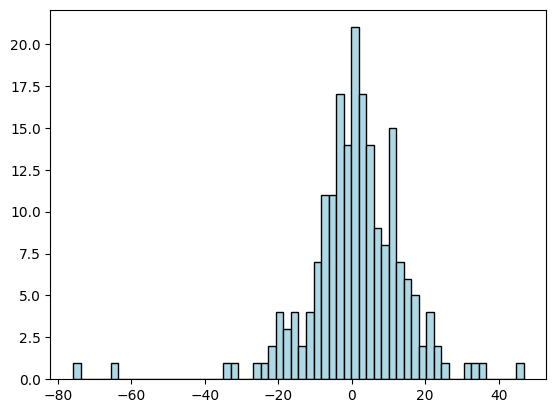

Train Time:  0.00246788699996614
#AR  12  RMSE : 13.568086895560436
min: -75.96237969443713 , max :  48.17785724087907
Mode error:  -1.4782375332473947


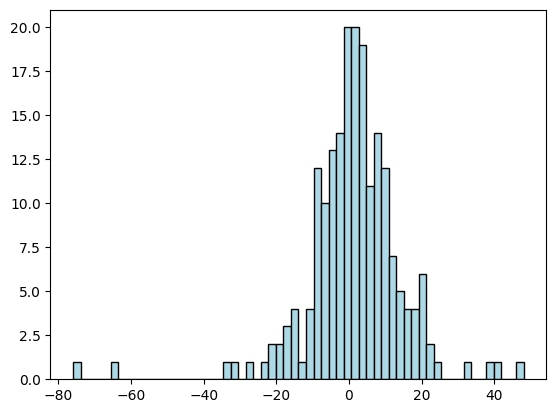

Train Time:  0.004839016000005358
#AR  13  RMSE : 13.047952062374113
min: -73.25851373740787 , max :  43.87743430774058
Mode error:  2.879852491938621


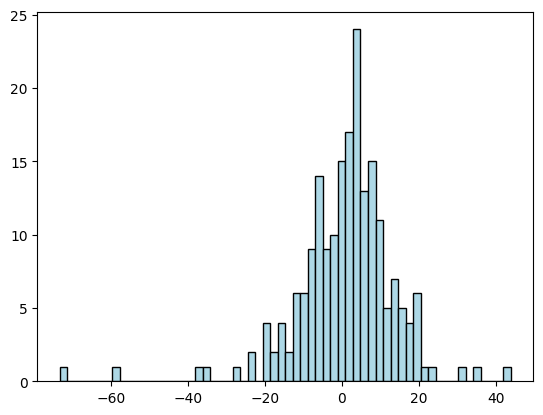

Train Time:  0.0025301770000396573
#AR  14  RMSE : 13.048346683318917
min: -72.21074519216992 , max :  43.80087348113861
Mode error:  3.196806945480631


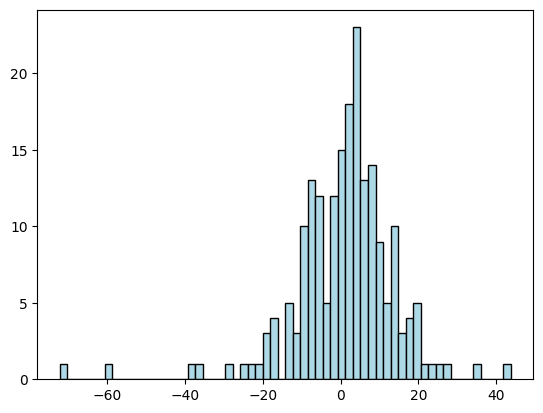

Train Time:  0.002812089999906675
#AR  15  RMSE : 13.13509873005957
min: -72.49794963886653 , max :  41.9065978739488
Mode error:  1.86500624446343


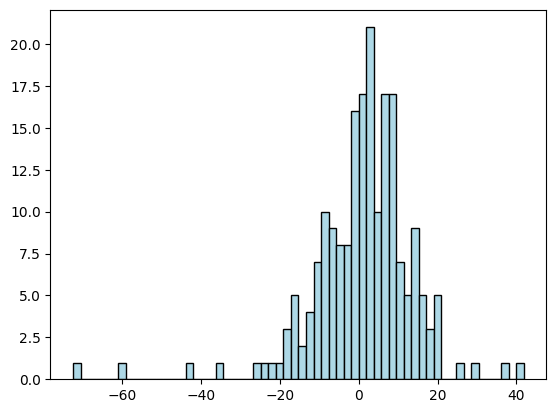

In [36]:
my_data = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=2,shiftAR=val,shiftARX=val-5,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data.append(data)
    

#AR  2  RMSE : 20.318432071489916
min: -92.675 , max :  57.0
Mode error:  -12.84833333333333


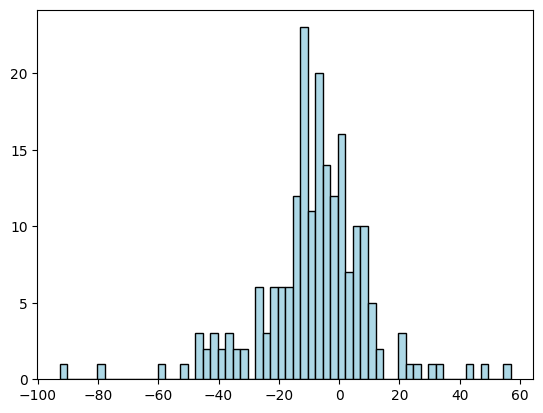

#AR  3  RMSE : 20.36356571421671
min: -83.11666666666666 , max :  60.0
Mode error:  -9.173055555555536


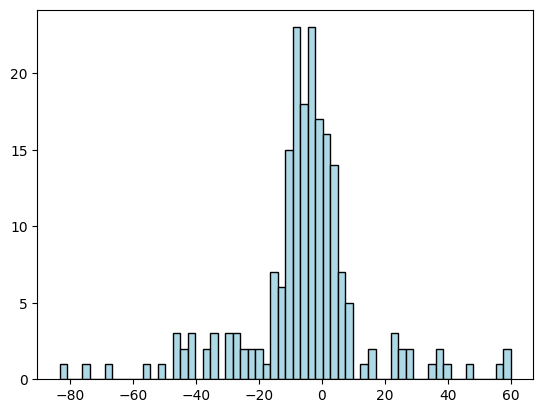

#AR  4  RMSE : 21.751449943109634
min: -84.0875 , max :  59.25
Mode error:  -7.640833333333333


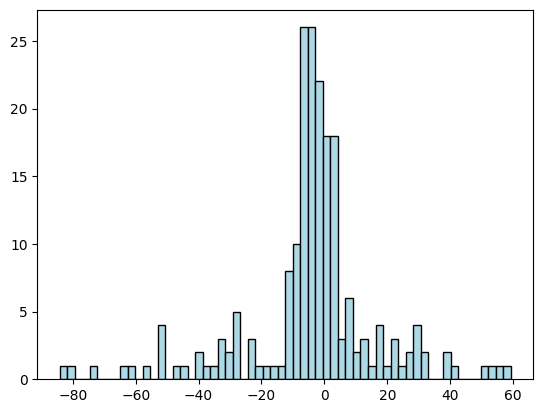

#AR  5  RMSE : 22.739982052800013
min: -84.67 , max :  54.0
Mode error:  -6.090333333333334


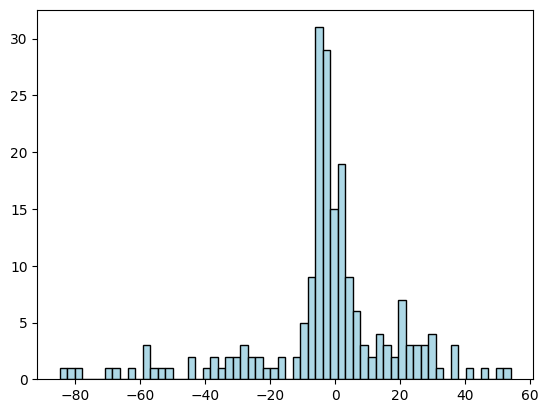

#AR  6  RMSE : 23.3074915098695
min: -85.05833333333334 , max :  46.666666666666664
Mode error:  -6.0233333333333405


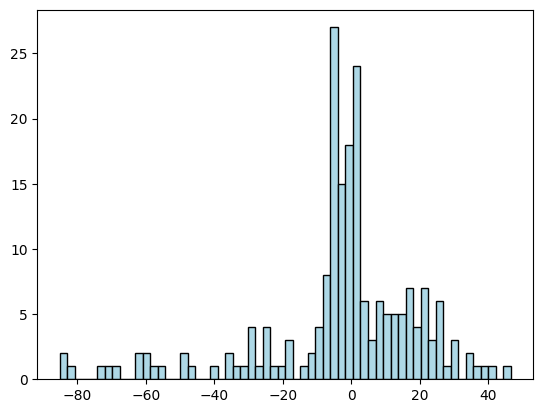

#AR  7  RMSE : 23.76907022157428
min: -85.47857142857143 , max :  41.57142857142857
Mode error:  -5.013571428571424


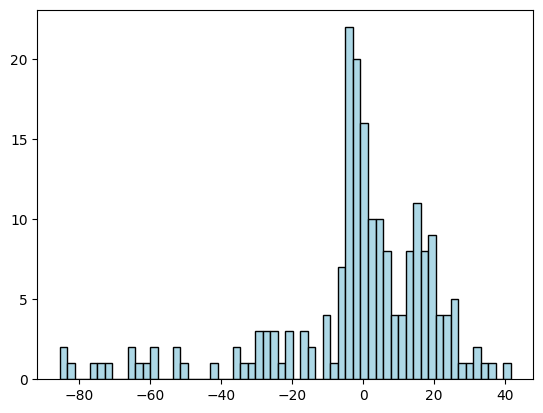

#AR  8  RMSE : 24.43290354600024
min: -85.66875 , max :  37.625
Mode error:  -3.472916666666663


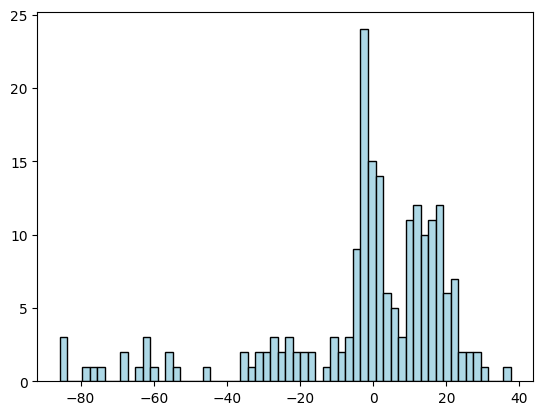

#AR  9  RMSE : 24.929672507522124
min: -86.15555555555555 , max :  34.77777777777778
Mode error:  -3.5177777777777663


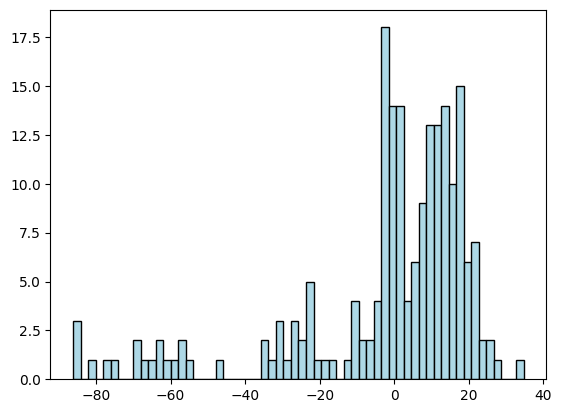

#AR  10  RMSE : 24.63858076498117
min: -86.64 , max :  32.3
Mode error:  8.512


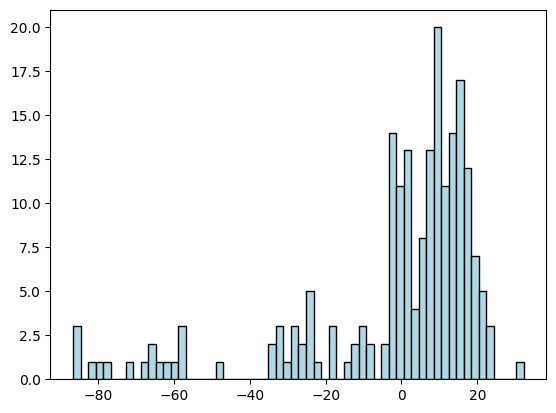

#AR  11  RMSE : 24.585006594803446
min: -86.94545454545454 , max :  30.363636363636367
Mode error:  6.9018181818182


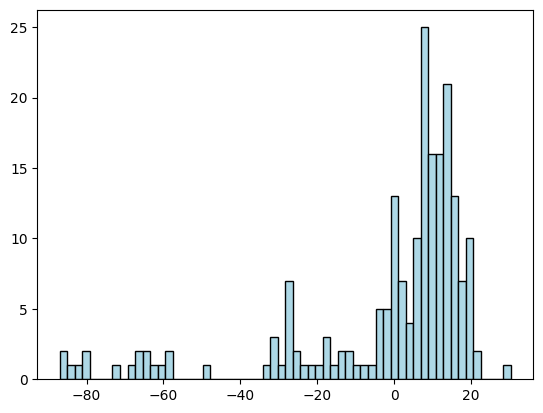

#AR  12  RMSE : 24.082690626456305
min: -85.1125 , max :  28.75
Mode error:  5.977500000000006


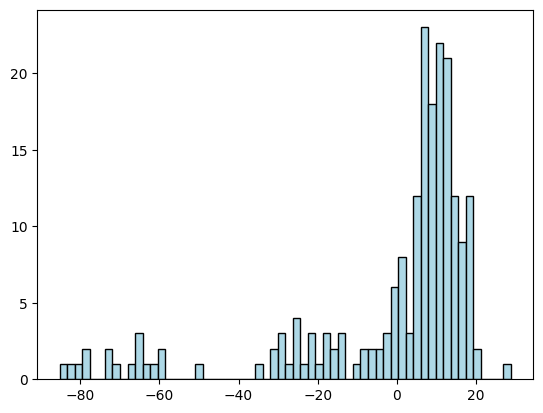

#AR  13  RMSE : 23.46349272792927
min: -79.71923076923076 , max :  27.307692307692307
Mode error:  5.902307692307701


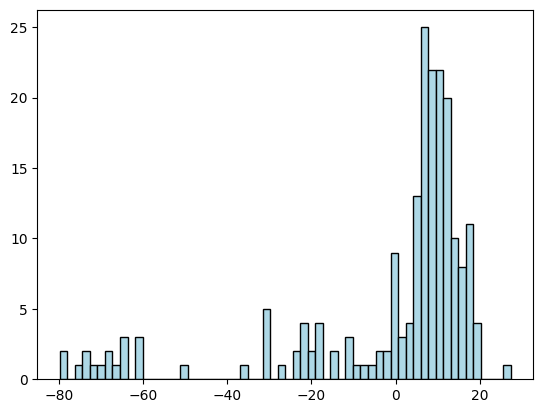

#AR  14  RMSE : 23.143464956882735
min: -78.81071428571428 , max :  26.142857142857146
Mode error:  8.650595238095235


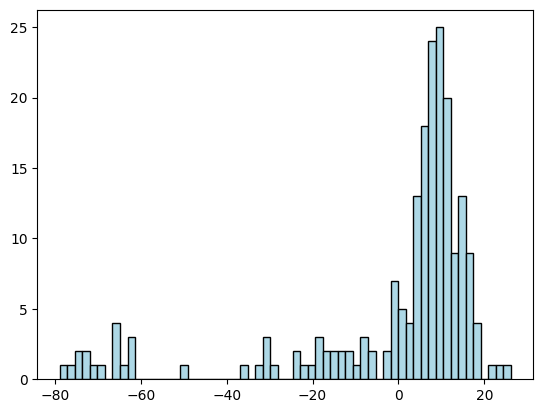

#AR  15  RMSE : 22.766880266892894
min: -78.15666666666667 , max :  25.616666666666667
Mode error:  8.321111111111122


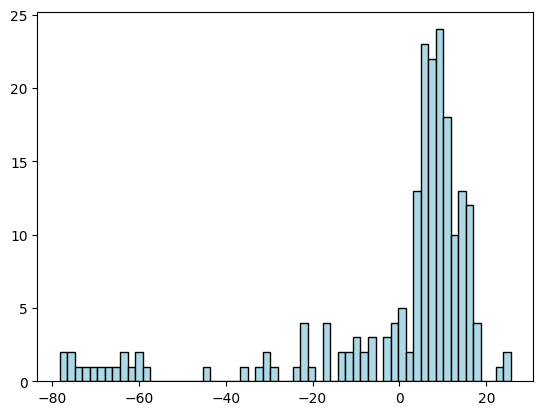

In [37]:
my_data_mean = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_Mean(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=5,shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_mean.append(data)

Train Time:  0.010972967999919092
SVR: #AR  2  RMSE : 18.664544589182942
min: -78.01870205812438 , max :  22.188342270522128
Mode error:  2.146933404792833


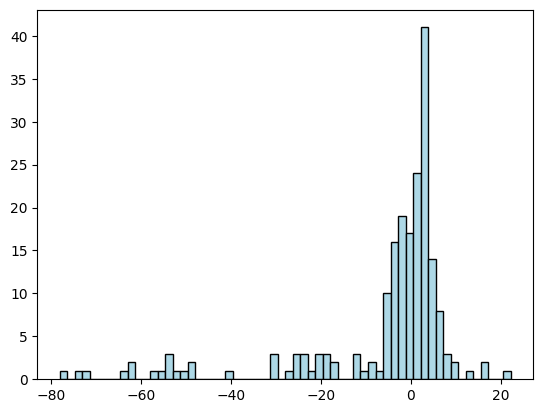

Train Time:  0.005382657999916773
SVR: #AR  3  RMSE : 19.33166518059845
min: -79.47352314624783 , max :  19.01417187655499
Mode error:  2.599556039421188


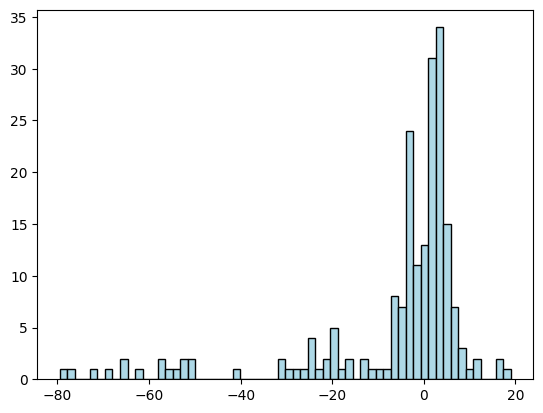

Train Time:  0.005817852999939532
SVR: #AR  4  RMSE : 19.90816107865154
min: -81.15779219909888 , max :  17.474669632277298
Mode error:  2.679800357570869


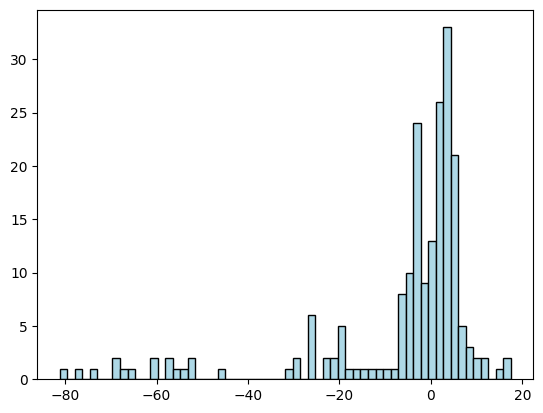

Train Time:  0.004812184000002162
SVR: #AR  5  RMSE : 20.204754575678272
min: -81.40347898254649 , max :  16.854313484540924
Mode error:  3.7532744889292644


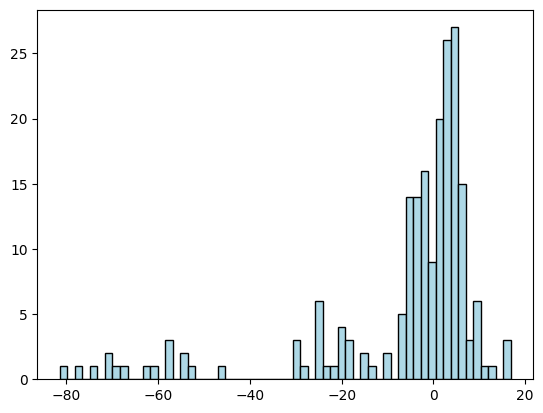

Train Time:  0.005126994000079321
SVR: #AR  6  RMSE : 20.20515633434629
min: -81.2739067265685 , max :  17.23321045917026
Mode error:  2.4571428813094514


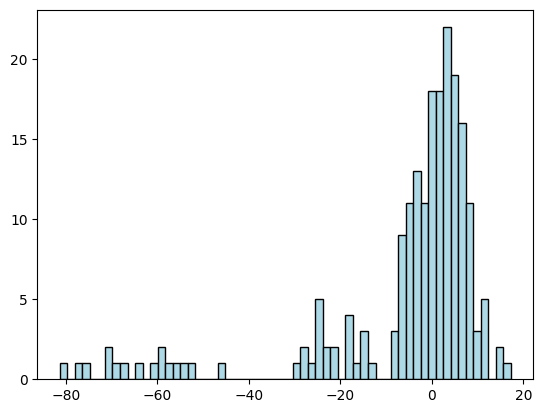

Train Time:  0.005425565999985338
SVR: #AR  7  RMSE : 20.368276682754217
min: -81.23060257663425 , max :  16.5049249412033
Mode error:  1.8445958135276612


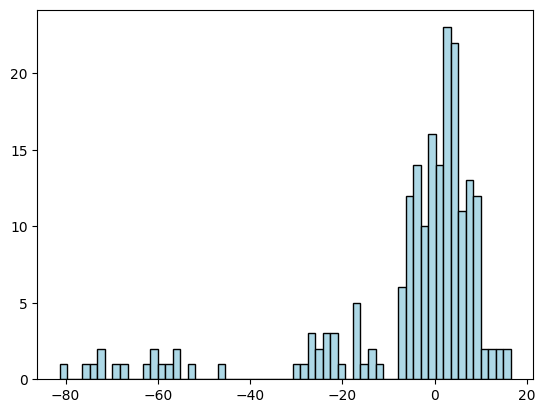

Train Time:  0.00548648200003754
SVR: #AR  8  RMSE : 21.04743834358193
min: -81.21289631022078 , max :  15.84981938200415
Mode error:  1.2904120281704223


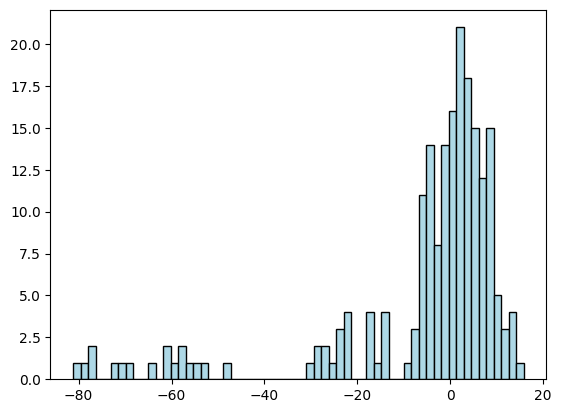

Train Time:  0.0059490260000529815
SVR: #AR  9  RMSE : 21.765933840628215
min: -82.63686764433638 , max :  14.654535825577618
Mode error:  1.6823486962557581


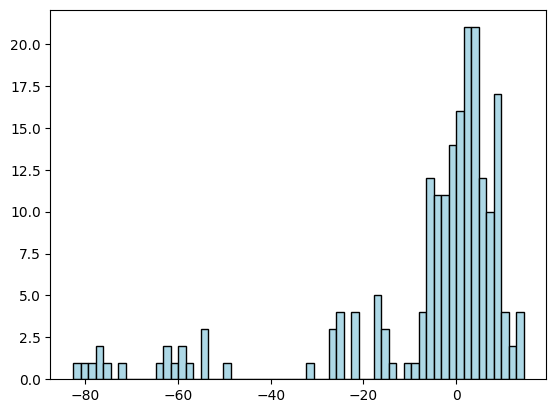

Train Time:  0.004946860000018205
SVR: #AR  10  RMSE : 21.430677294700196
min: -82.54091609135175 , max :  14.083823754621896
Mode error:  1.200525108492073


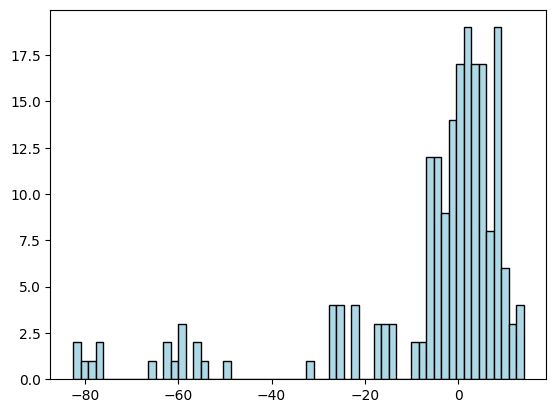

Train Time:  0.005399374000035095
SVR: #AR  11  RMSE : 21.746341958738576
min: -83.0955052598406 , max :  13.530006994545499
Mode error:  2.2570305648671223


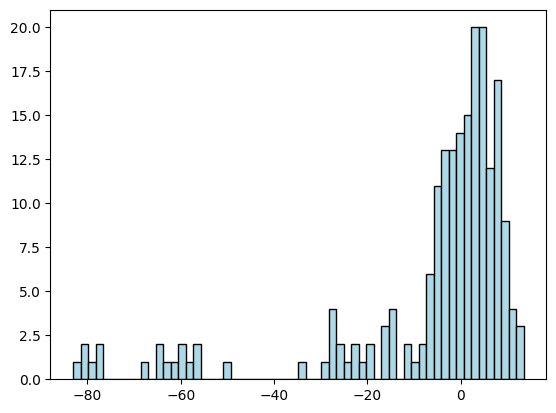

Train Time:  0.005629715000054603
SVR: #AR  12  RMSE : 21.93319706017808
min: -83.57616056453963 , max :  13.369580502591646
Mode error:  2.0592440447596516


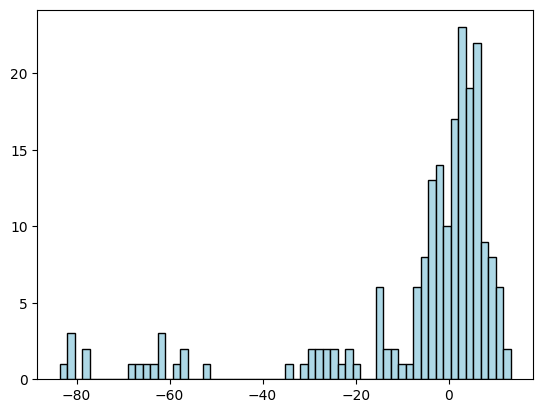

Train Time:  0.005810339999925418
SVR: #AR  13  RMSE : 22.09162286316276
min: -83.57798613684692 , max :  13.029765978161212
Mode error:  1.7588615647435972


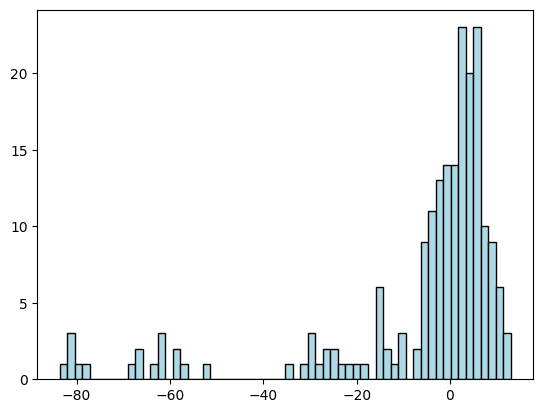

Train Time:  0.0060254620000250725
SVR: #AR  14  RMSE : 22.188048671434636
min: -83.57192385896326 , max :  13.03829459245447
Mode error:  3.377272747312688


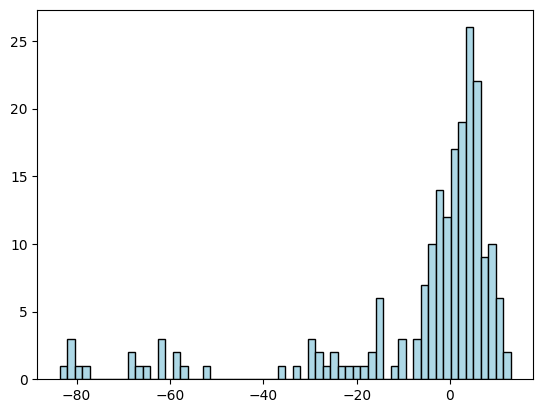

Train Time:  0.0063636900000574315
SVR: #AR  15  RMSE : 22.245177560681373
min: -83.89954168524947 , max :  13.062678004117181
Mode error:  3.3664560351805193


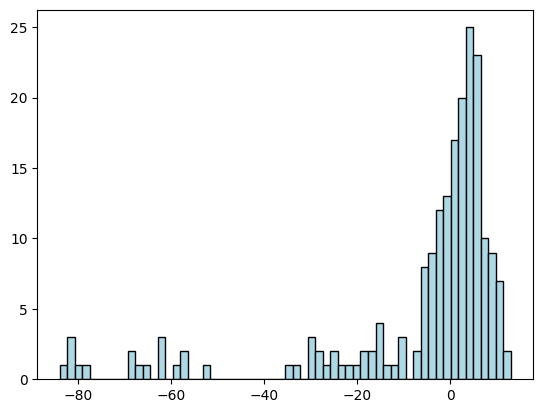

In [38]:
my_data_svr = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_SVR(file,padding=pad,\
                                                                            endog=test_endog,Kernel='rbf',N_CLUST=0,\
                                                                            shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("SVR: #AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_svr.append(data)

Train Time:  2.1207194050000453
LSTM: #AR  4  RMSE : 13.570086529687767
min: -61.34819412231445 , max :  45.8736572265625
Mode error:  2.9849166870117188


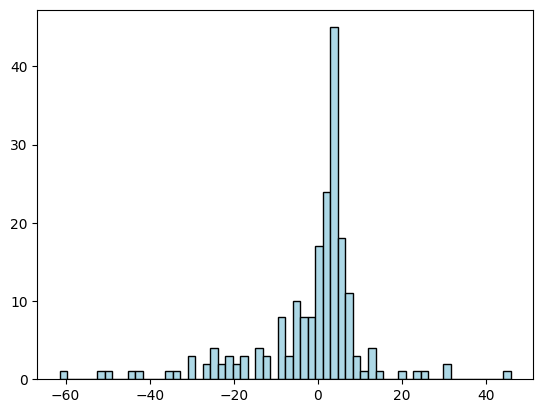

Train Time:  2.7430216489999566
LSTM: #AR  6  RMSE : 15.917301279099405
min: -62.51729965209961 , max :  43.488487243652344
Mode error:  1.086172485351561


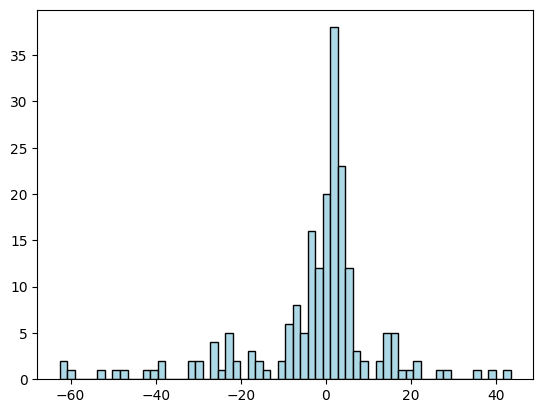

Train Time:  2.2548461730000326
LSTM: #AR  8  RMSE : 13.39830383900895
min: -62.119842529296875 , max :  36.39073181152344
Mode error:  -1.371655019124347


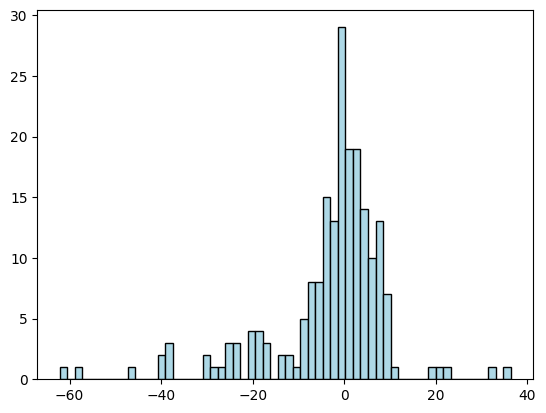

Train Time:  2.19327659399994
LSTM: #AR  10  RMSE : 11.891469972440936
min: -67.01665878295898 , max :  40.886383056640625
Mode error:  -2.2748336791992188


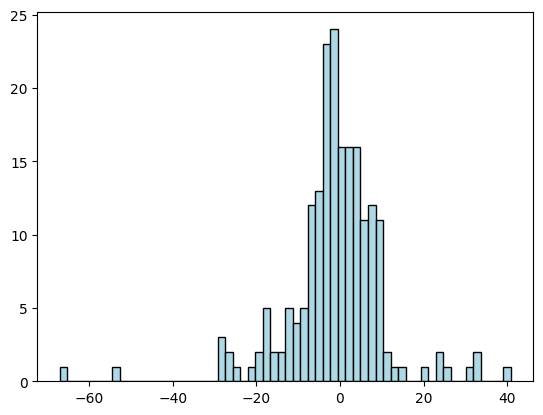

Train Time:  2.3939295489999495
LSTM: #AR  12  RMSE : 12.115610388564162
min: -35.833282470703125 , max :  58.881378173828125
Mode error:  3.631159464518234


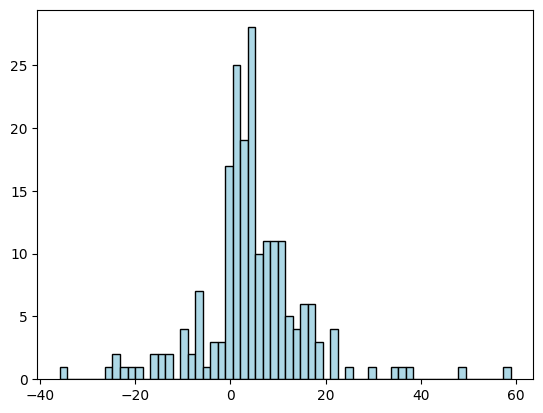

Train Time:  2.092446273000064
LSTM: #AR  14  RMSE : 12.611800051885444
min: -56.973426818847656 , max :  42.241241455078125
Mode error:  2.5553741455078125


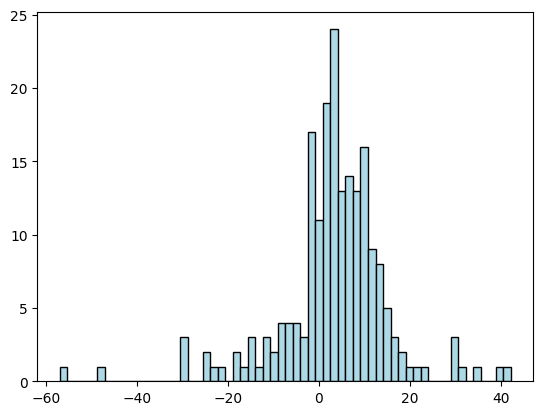

In [39]:
my_data_lstm = []
for val in range(4,16,2):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_LSTM(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=2,shiftAR=val,shiftARX=0,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    
    print("LSTM: #AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_lstm.append(data)

In [40]:
my_data

[(2, 13.031506644939105, 10.5, 0.809947709825528),
 (3, 13.272524030757008, 10.5, 0.8093102883379246),
 (4, 13.572148987108235, 11.0, 0.8143100826446281),
 (5, 13.926056259410673, 11.0, 0.8105362571166208),
 (6, 14.263006917609292, 10.5, 0.8105963562901746),
 (7, 14.180391958790683, 9.0, 0.8117340606060607),
 (8, 14.08723914630909, 10.0, 0.8101400404040405),
 (9, 14.1059134006367, 10.0, 0.8105416786042242),
 (10, 13.643076368858036, 10.0, 0.7977124040404041),
 (11, 13.699295134337634, 11.0, 0.7985225638200185),
 (12, 13.568086895560436, 10.5, 0.8029448668503216),
 (13, 13.047952062374113, 10.0, 0.8087083562901748),
 (14, 13.048346683318917, 9.5, 0.8051073057851243),
 (15, 13.13509873005957, 9.5, 0.8038171533516991)]

In [41]:
my_data_lstm

[(4, 13.570086529687767, 13.5, 0.8376212378328747),
 (6, 15.917301279099405, 14.5, 0.833238905417815),
 (8, 13.39830383900895, 14.0, 0.8392847382920116),
 (10, 11.891469972440936, 12.5, 0.80875868503214),
 (12, 12.115610388564162, 6.0, 0.7670684958677685),
 (14, 12.611800051885444, 7.0, 0.7809389311294764)]

In [43]:
my_data_svr

[(2, 18.664544589182942, 18.0, 0.8933570027548212),
 (3, 19.33166518059845, 18.5, 0.8966217373737376),
 (4, 19.90816107865154, 18.5, 0.8968014104683198),
 (5, 20.204754575678272, 19.0, 0.8946782956841142),
 (6, 20.20515633434629, 18.0, 0.8933818255280076),
 (7, 20.368276682754217, 18.0, 0.8934392800734622),
 (8, 21.04743834358193, 18.0, 0.8930120110192841),
 (9, 21.765933840628215, 18.0, 0.8943155482093665),
 (10, 21.430677294700196, 19.0, 0.8975886721763087),
 (11, 21.746341958738576, 18.5, 0.9066860532598716),
 (12, 21.93319706017808, 18.5, 0.9107658622589533),
 (13, 22.09162286316276, 18.0, 0.9155062773186411),
 (14, 22.188048671434636, 17.5, 0.9159704168962352),
 (15, 22.245177560681373, 17.5, 0.9162142295684115)]

In [44]:
my_data_mean

[(2, 20.318432071489916, 22.5, 0.8462599155188251),
 (3, 20.36356571421671, 21.5, 0.8387378292011024),
 (4, 21.751449943109634, 21.0, 0.8402417263544542),
 (5, 22.739982052800013, 20.5, 0.8454353498622594),
 (6, 23.3074915098695, 19.0, 0.8482977630854),
 (7, 23.76907022157428, 20.0, 0.8497406060606065),
 (8, 24.43290354600024, 19.5, 0.8435855059687792),
 (9, 24.929672507522124, 19.0, 0.8500408888888893),
 (10, 24.63858076498117, 18.0, 0.8564801836547296),
 (11, 24.585006594803446, 17.5, 0.8622807125803493),
 (12, 24.082690626456305, 16.5, 0.865656741965106),
 (13, 23.46349272792927, 16.0, 0.8647741634527093),
 (14, 23.143464956882735, 13.5, 0.8679208888888893),
 (15, 22.766880266892894, 13.5, 0.8676332561983475)]

In [32]:
x = list(map(lambda x: x[0], my_data))
y = list(map(lambda x: x[3], my_data))
y_svr = list(map(lambda x: x[1], my_data_svr))
y_mean = list(map(lambda x: x[1], my_data_mean))

In [86]:
# ##Combined Plot
# plt.plot(x, y, label='Our Method') 
# # plt.plot(x, y_svr, label='SVR') 
# # plt.plot(x, y_mean, label='Mean') 

# plt.xlabel("AR") 
# plt.ylabel("Energy") 
# plt.title("Comparing Model") 
# plt.legend() 
# plt.show() 

## Mem Values

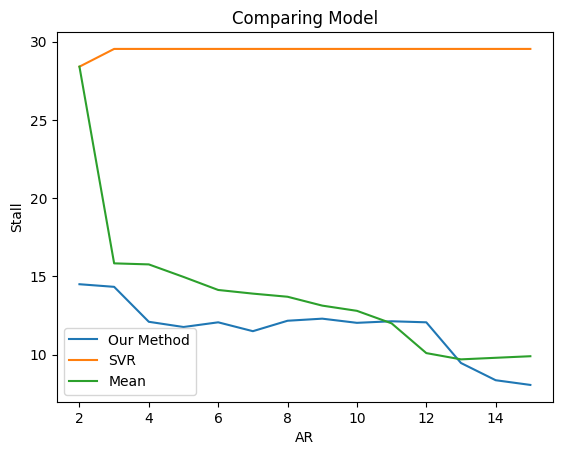

In [69]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

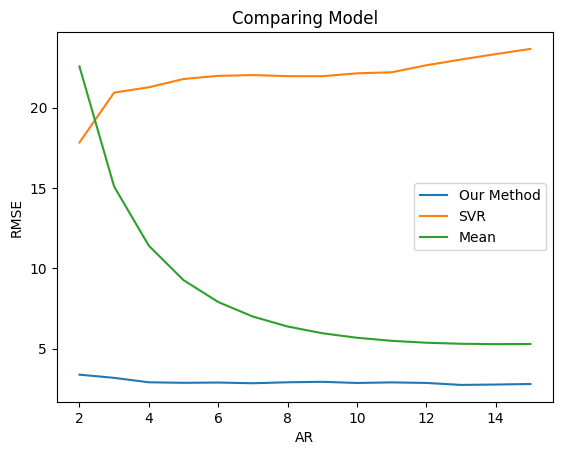

In [67]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

## CPU Values

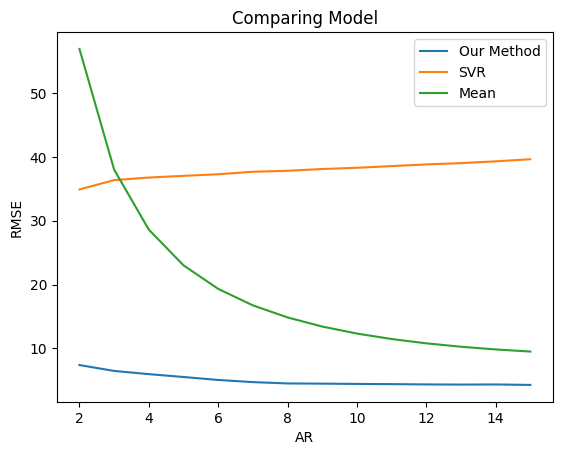

In [78]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show()

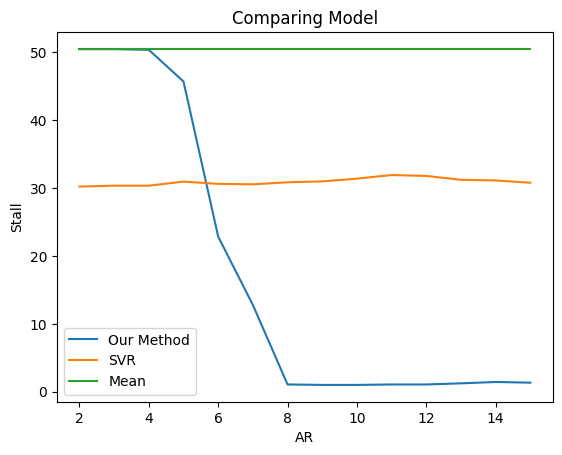

In [59]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

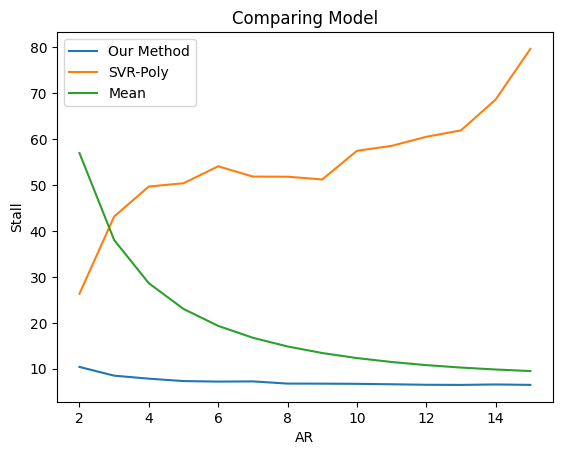

In [39]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR-Poly') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

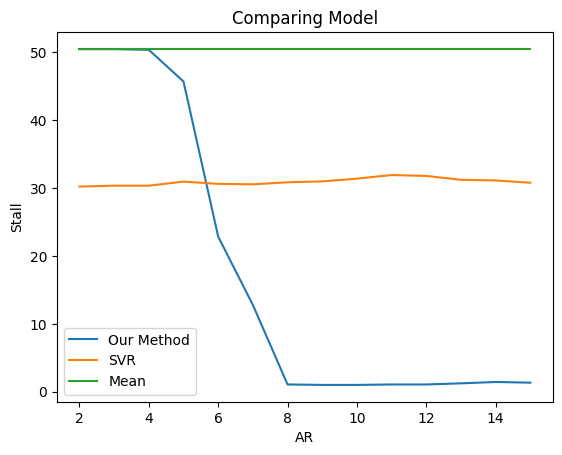

In [58]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 